In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Cargar el conjunto de datos
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist['data'] / 255, mnist['target']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 / 3, random_state=42)
n = X_train.shape[0]
print(n)

# Parámetros de la red neuronal
L = 0.01  # Tasa de aprendizaje
num_iterations = 5_000
batch_size = 1024

# Preguntar al usuario si desea cargar los parámetros antiguos o entrenar desde cero
user_choice = input("Cargar parametros antiguos (c) o entrenar desde cero (e)? ")

#! Inicializar los parametros de la red neuronal ===============================================

#model_params_file = "model_params.npz" #este tiene precision del 90.25027856%
#model_params_file = "model_params_1.npz" #este tiene precision del 36% por ahi
#model_params_file = "model_params_2.npz" #este tiene precision del 90.99597154%  se creo desde model_params
#model_params_file = "model_params_3.npz" #este tiene precision del 91.38596040%  se creo desde model_params_2
#model_params_file = "model_params_4.npz" #este tiene precision del 93.56304106%  se creo desde model_params_3
model_params_file = "model_params_5.npz" #este tiene precision del 94.95157281%  se creo desde model_params_4

#! Inicializar los parametros de la red neuronal ===============================================

# Inicializar pesos y bias
if user_choice.lower() == 'c' and os.path.exists(model_params_file):
    # Cargar los pesos y los bias desde el archivo .npz
    try:
        params = np.load(model_params_file)
        w_1 = params['w_1']
        b_1 = params['b_1']
        w_2 = params['w_2']
        b_2 = params['b_2']
        w_3 = params['w_3']
        b_3 = params['b_3']
        print(f"Parametros cargados desde '{model_params_file}'.")
    except Exception as e:
        print(f"Error al cargar parametros: {e}")
        # Inicializar aleatoriamente si hay un error
        np.random.seed(13)
        w_1 = np.random.randn(256, 784) * 0.01
        w_2 = np.random.randn(128, 256) * 0.01
        w_3 = np.random.randn(10, 128) * 0.01
        b_1 = np.random.rand(256, 1)
        b_2 = np.random.rand(128, 1)
        b_3 = np.random.rand(10, 1)
        print("Parametros inicializados aleatoriamente.")
else:
    # Inicializar aleatoriamente los pesos y bias
    np.random.seed(13)
    w_1 = np.random.randn(256, 784) * 0.01
    w_2 = np.random.randn(128, 256) * 0.01
    w_3 = np.random.randn(10, 128) * 0.01
    b_1 = np.random.rand(256, 1)
    b_2 = np.random.rand(128, 1)
    b_3 = np.random.rand(10, 1)
    print("Parametros inicializados aleatoriamente.")

# Funciones de activación
relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Derivadas de las funciones de activación
d_relu = lambda x: x > 0

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y.astype(int), np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    # Convertir Y a codificación one-hot
    one_hot_Y = one_hot(Y, A3.shape[0])
    
    dCE_dZ3 = A3 - one_hot_Y
    dZ3_dW3 = A2  
    dZ3_dB3 = 1
    dZ3_dA2 = w_3
    dA2_dZ2 = d_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dZ2_dA1 = w_2
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    # Calcular gradientes para W3 y b3
    dCE_dW3 = dCE_dZ3 @ dZ3_dW3.T / X.shape[1]
    dCE_dB3 = np.sum(dCE_dZ3, axis=1, keepdims=True) / X.shape[1]

    dCE_dA2 = dZ3_dA2.T @ dCE_dZ3
    dCE_dZ2 = dCE_dA2 * dA2_dZ2

    # Calcular gradientes para W2 y b2
    dCE_dW2 = dCE_dZ2 @ dZ2_dW2.T / X.shape[1]
    dCE_dB2 = np.sum(dCE_dZ2, axis=1, keepdims=True) / X.shape[1]

    dCE_dA1 = dZ2_dA1.T @ dCE_dZ2
    dCE_dZ1 = dCE_dA1 * dA1_dZ1

    # Calcular gradientes para W1 y b1
    dCE_dW1 = dCE_dZ1 @ dZ1_dW1.T / X.shape[1]
    dCE_dB1 = np.sum(dCE_dA1, axis=1, keepdims=True) / X.shape[1]

    return dCE_dW1, dCE_dB1, dCE_dW2, dCE_dB2, dCE_dW3, dCE_dB3

def calculate_accuracy(Y_true, Y_pred):
    return np.mean(Y_true == Y_pred)

# Entrenamiento por descenso de gradiente
accuracy_train_l = []
accuracy_test_l = []
for i in tqdm(range(num_iterations), desc="Training", unit="iteration"):
    np.random.seed(13)
    idx = np.random.choice(n, batch_size, replace=False)
    X_sample = X_train.iloc[idx].to_numpy().transpose()  # Transponer a (784, 4096)
    Y_sample = Y_train.iloc[idx].to_numpy()

    # Propagación hacia adelante
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    # Propagación hacia atrás
    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    # Actualizar pesos y bias
    w_1 -= L * dW1
    b_1 -= L * dB1
    w_2 -= L * dW2
    b_2 -= L * dB2
    w_3 -= L * dW3
    b_3 -= L * dB3

    # if i % 100 == 0:
        # Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = forward_prop(X_test.transpose())
        # predictions = np.argmax(A3_test, axis=0)
        # accuracy = accuracy_score(Y_test.astype(int), predictions)
        # accuracies.append(accuracy)  # Guardar la precisión
        # print(f"Iteración {i}, Precisión: {accuracy * 100:.8f}%")

    Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = forward_prop(X_test.transpose())
    test_predictions = np.argmax(A3_test, axis=0)
    
    # Calcular precisión del conjunto de prueba
    accuracy_test = np.mean(test_predictions == Y_test.astype(int))
    accuracy_test_l.append(accuracy_test)  # Asegúrate de acumular en la lista correcta

    # Calcular precisión del conjunto de entrenamiento
    train_predictions = np.argmax(A3, axis=0)
    accuracy_train = np.mean(train_predictions == Y_sample.astype(int))
    accuracy_train_l.append(accuracy_train)  # Asegúrate de acumular en la lista correcta

# Imprimir la precisión final
print(f"Precision de prueba final: {accuracy_test_l[-1] * 100:.8f}  Precision de entrenamiento final: {accuracy_train_l[-1] * 100:.8f}")

# # Guardar parametros al final del entrenamiento
# i = 0
# new_model_params_file = model_params_file
# while os.path.exists(new_model_params_file):
    # i += 1
    # new_model_params_file = f"model_params_{i}.npz"

# np.savez(new_model_params_file, w_1=w_1, b_1=b_1, w_2=w_2, b_2=b_2, w_3=w_3, b_3=b_3)
# print(f"Parametros guardados en '{new_model_params_file}'.")


46666
Parametros inicializados aleatoriamente.


Training: 100%|██████████| 5000/5000 [25:40<00:00,  3.25iteration/s]

Precision de prueba final: 82.67335219  Precision de entrenamiento final: 93.65234375


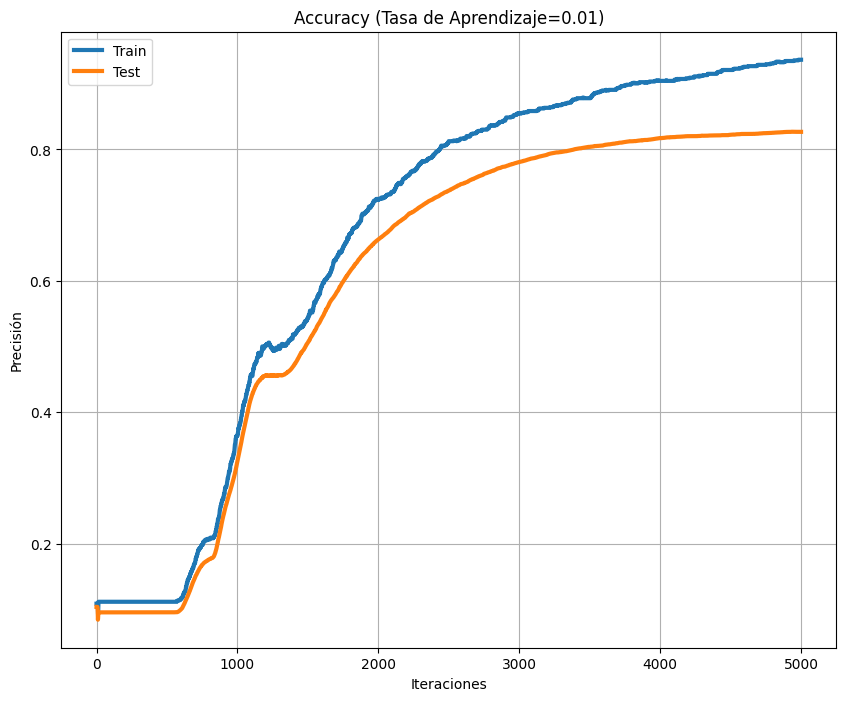

In [32]:
def accuracy_graphic(L, train_l, test_l):
    iters = len(train_l)
    fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
    fmt_test = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(range(iters), train_l, label='Train', **fmt_train)
    ax.plot(range(iters), test_l, label='Test', **fmt_test)
    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy (Tasa de Aprendizaje={L})')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Precisión')
    plt.savefig(f"accuracy_{L}.png")  # Guardar la figura
    plt.show()

accuracy_graphic(L, accuracy_train_l, accuracy_test_l)

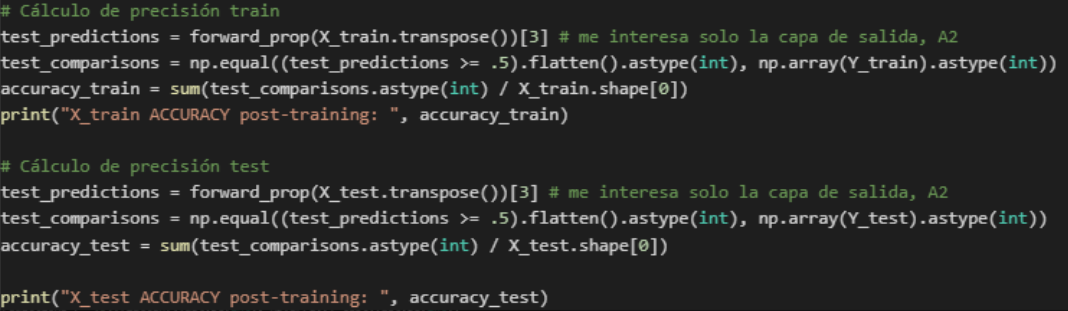